In [1]:
import numpy as np
from numpy.polynomial.legendre import Legendre, leggauss
import matplotlib.pyplot as plt
import pandas as pd

## Computing Gauss-Lobatto nodes and weights

The Legendre-Gauss-Lobatto (LGL) nodes $x_i$, $i=0,\dots,N$, are given by the roots of the polynomial
$$
P_N(x) = (1-x^2)L_N'(x),
$$ 
where $L_N$ is the Legendre polynomial of degree $N$ and the quadrature weights are given by
$$ 
\begin{align*}
    w_i = \frac{2}{N(N+1)}\frac{1}{[L_N(x_i)]^2},\hspace{10pt}i=0,\dots,N
\end{align*}
$$

In [2]:
def compute_nodes_weights(N):
    """
    Return Gauss-Lobatto nodes xi[0..N] and weights w[0..N] on [-1,1] for degree N.
    """
    # quadrature points
    xi = np.zeros(N+1)
    xi[0], xi[N] = -1.0, 1.0
    if N > 1:  
        L = Legendre(np.concatenate((np.zeros(N), [1])))        # Legendre polynomial L_N
        roots = L.deriv().roots()   
        xi[1:N] = np.sort(np.real(roots))
    
    # quadrature weights
    P_N = Legendre(np.concatenate((np.zeros(N), [1])))
    P_val = P_N(xi)
    w = np.zeros(N+1)
    for i in range(N+1):
        w[i] = 2.0/(N*(N+1) * (P_val[i]**2))
    return xi, w

In [3]:
compute_nodes_weights(3)

(array([-1.       , -0.4472136,  0.4472136,  1.       ]),
 array([0.16666667, 0.83333333, 0.83333333, 0.16666667]))

## Computing local stiffness matrix and rhs

In [4]:
# Barycentric weights and derivative matrix for Lagrange basis at nodes
def barycentric_weights(x):
    """Compute barycentric interpolation weights w_i = 1/∏(x_i-x_j) for nodes x."""
    n = len(x)
    w = np.ones(n)
    for i in range(n):
        prod = 1.0
        for j in range(n):
            if j != i:
                prod *= (x[i] - x[j])
        w[i] = 1.0/prod
    return w

def lagrange_derivative_matrix(x):
    """
    Compute the matrix D where D[k,i] = d/dξ (ℓ_i)(x_k),
    the derivative of the i-th Lagrange basis at node x_k.
    """
    n = len(x)
    D = np.zeros((n,n))
    w = barycentric_weights(x)
    for k in range(n):
        for i in range(n):
            if k != i:
                D[k,i] = w[i] / (w[k]*(x[k]-x[i]))
        D[k,k] = - np.sum(D[k,:])
    return D

In [5]:
# Element stiffness matrix and load vector assembly
def local_element_matrix(N, a, b, f_func,alpha, beta, gamma):
    """
    Compute local stiffness K_e (size (N+1)x(N+1)) and load F_e for element [a,b].
    """
    xi_ref, w_ref = compute_nodes_weights(N)      # nodes and weights on [-1,1]
    D = lagrange_derivative_matrix(xi_ref)    # derivative matrix on reference
    h = b - a
    K_e = np.zeros((N+1,N+1))

    # Local stiffness via quadrature
    if alpha!=0:                               # non-zero diffusion term
        S_ref = D.T @ np.diag(w_ref) @ D       # ∫ ℓ'_i ℓ'_j dξ approximated using quadrature
        S_e = (2/h) * S_ref                    
        K_e += alpha*S_e                   
    
    # Local mass via quadrature
    if gamma!=0:                                # non-zero reaction term
        M_ref = np.diag(w_ref)                  # ∫ ℓ_i ℓ_j dξ approximated using quadrature
        M_e = (h/2) * M_ref                     
        K_e += gamma*M_e

    # Local advection via quadrature
    if beta!=0:                                 # non-zero advection term
        A_ref = D.T @ np.diag(w_ref) @ D        # ∫ ℓ'_i ℓ_j dξ approximated using quadrature
        A_e = (2/h) * A_ref                     
        K_e += -beta*A_e

    # Local load via collocation
    x_phys = (a+b)/2 + (h/2)*xi_ref           # nodes on [a,b]
    f_vals = f_func(x_phys)
    F_e = (h/2) * (f_vals* w_ref)
    return K_e, F_e, x_phys


## Assembling the global stiffness matrix and rhs

In [6]:
# Global assembly over all elements
def assemble_global_system(N, NE, f_func,a,b,alpha, beta, gamma):
    """
    Assemble global stiffness matrix K and load vector F for NE elements of degree N on [a,b].
    """
    L = np.abs(b-a) 
    h = L/NE
    n_dof = N*NE + 1
    K = np.zeros((n_dof, n_dof))
    F = np.zeros(n_dof)
    for e in range(NE):
        xi= a + e*h
        xi_1 = a+ (e+1)*h
        K_e, F_e, _ = local_element_matrix(N, xi, xi_1, f_func,alpha,beta,gamma)

        # Map local to global indices
        start = e*N
        for i in range(N+1):
            I = start + i
            F[I] += F_e[i]
            for j in range(N+1):
                J = start + j
                K[I,J] += K_e[i,j]
    return K, F

## Plotting mesh nodes and interpolation points 

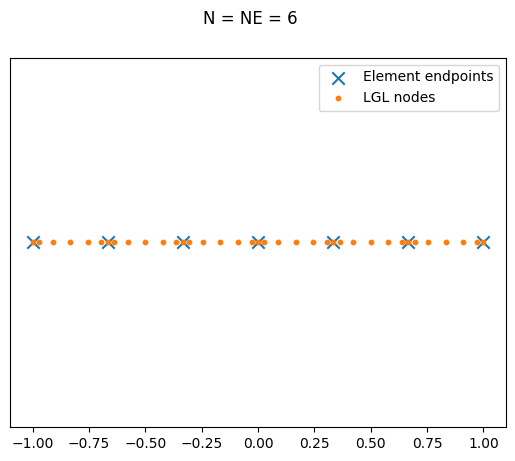

In [7]:
# Build global node coordinates in [-1,1]
N = 6
NE = 6
a = -1
b = 1
X = np.zeros(N*NE+1)
h = (b-a)/NE
for i in range(NE):
    xi_ref, _ = compute_nodes_weights(N)
    xi, xi_1 = a + i*h, a + (i+1)*h
    X[i*N:(i+1)*N+1] = 0.5*(xi+xi_1) + 0.5*(xi_1-xi)*xi_ref


plt.scatter(x=np.linspace(-1,1,N+1),y=np.zeros(N+1),label = "Element endpoints", marker = "x", s= 80)
plt.scatter(x=X,y=np.zeros(len(X)),label = "LGL nodes", marker= "o",s=10)
plt.legend()
plt.gca().get_yaxis().set_visible(False)
plt.suptitle("N = NE = 6")
plt.show()

## Imposing Dirichlet boundary condition

In [8]:
def apply_dirichlet(K, F):
    """
    Enforce u(0)=u(1)=0 by modifying K and F.
    X is the global node coordinates.
    """

    K[0,:] = 0;   K[0,0] = 1;   F[0] = 0
    K[-1,:] = 0;  K[-1,-1] = 1;  F[-1] = 0

## Computing errors and convergence rate

In [9]:
#computing the error as compared to the exact solution in L2 and H1 norm
def compute_errors(u_num, X, N, NE, u_exact, du_exact, a, b):
    L2_sq = 0.0
    H1_sq = 0.0
    h = (b - a) / NE

    m = N + 3  # Quadrature order
    gl_x, gl_w = leggauss(m)

    for e in range(NE):
        x0 = a + e*h
        x1 = a + (e+1)*h
        J = (x1 - x0) / 2
        start = e*N
        u_loc = u_num[start:start+N+1]

        xi_ref, _ = compute_nodes_weights(N)
        coeffs = np.polyfit(xi_ref, u_loc, N)
        p = np.poly1d(coeffs)
        dp = np.polyder(p)

        for i in range(m):
            xi = gl_x[i]
            weight = gl_w[i]
            x_phys = (x0 + x1)/2 + J * xi

            u_h = p(xi)
            u_h_deriv = dp(xi) * (2/h) 
            u_ex = u_exact(x_phys)
            u_ex_deriv = du_exact(x_phys)

            L2_sq += weight * (u_h - u_ex)**2 * J
            H1_sq += weight * (u_h_deriv - u_ex_deriv)**2 * J

    return np.sqrt(L2_sq), np.sqrt(H1_sq)

In [10]:
# spectral and logarithmic rate
def spectral_rates(errors, N_values):
    errors = np.array(errors)
    N_vals = np.array(N_values)
    return -np.diff(np.log(errors)) / np.diff(N_vals)

def log_rates(errors, h_ratio):
  return np.log(errors[:-1]/errors[1:])/np.log(h_ratio)

## Convergence study for Poisson problem

### Example

Consider the following problem
$$
\begin{equation*}
    \begin{split}
        -\Delta u + u &=(\pi^2+1)\sin(\pi x),\text{ in }(0,1)\\
        u(0) &= u(1) = 0
    \end{split}
\end{equation*}
$$
The exact solution for this problem is given by $u(x) = \sin(\pi x)$.

In [11]:
alpha, beta, gamma = 1,0,1

# -- Define exact solution and RHS f --
def f_func(x):
    return (np.pi**2+1)*np.sin(np.pi*x)

def u_exact(x):
    return np.sin(np.pi*x)

def du_exact(x):
    return np.pi*np.cos(np.pi*x)

In [12]:
def prepend_nan(array):
  return np.concatenate(([np.nan], array))  

#### Convergence behavior with increasing number of elements

In [13]:
a,b = 0,1                       #interval endpoints
NE_values = 2**np.arange(1,6)
N_values = [2,4]

for N in N_values:
    L2_err = []
    H1_err = []
    for NE in NE_values:
        K, F = assemble_global_system(N, NE, f_func, a,b, alpha, beta, gamma)

        # Build global node coordinates X
        X = np.zeros(N*NE+1)
        h = (b-a)/NE
        for i in range(NE):
            xi_ref, _ = compute_nodes_weights(N)
            xi, xi_1 = a + i*h, a + (i+1)*h
            X[i*N:(i+1)*N+1] = 0.5*(xi+xi_1) + 0.5*(xi_1-xi)*xi_ref

        # Enforce boundary conditions
        apply_dirichlet(K, F)

        # Solve linear system
        u_num = np.linalg.solve(K, F)

        # Compute errors
        l2_err, h1_err = compute_errors(u_num, X, N, NE, u_exact,du_exact, a,b)
        L2_err.append(l2_err)
        H1_err.append(h1_err)
        
    L2_err = np.array(L2_err)
    H1_err = np.array(H1_err)
    L2_rate = prepend_nan(log_rates(L2_err,2))
    H1_rate = prepend_nan(log_rates(H1_err,2))

    print("-"*50)
    print("N =",N)
    df = pd.DataFrame(data=np.transpose([NE_values,L2_err,L2_rate,H1_err,H1_rate]),columns=["Number of elements", "L2-Error","L2-Rate", "H1-Error","H1-Rate"])
    print(df)

--------------------------------------------------
N = 2
   Number of elements  L2-Error   L2-Rate  H1-Error   H1-Rate
0                 2.0  0.017887       NaN  0.206590       NaN
1                 4.0  0.002034  3.136829  0.051210  2.012278
2                 8.0  0.000248  3.034330  0.012776  2.003007
3                16.0  0.000031  3.008592  0.003192  2.000747
4                32.0  0.000004  3.002149  0.000798  2.000186
--------------------------------------------------
N = 4
   Number of elements      L2-Error   L2-Rate      H1-Error   H1-Rate
0                 2.0  1.075629e-04       NaN  2.637394e-03       NaN
1                 4.0  3.374269e-06  4.994462  1.669890e-04  3.981288
2                 8.0  1.055485e-07  4.998597  1.047068e-05  3.995326
3                16.0  3.299197e-09  4.999648  6.549478e-07  3.998832
4                32.0  1.031064e-10  4.999909  4.094252e-08  3.999708


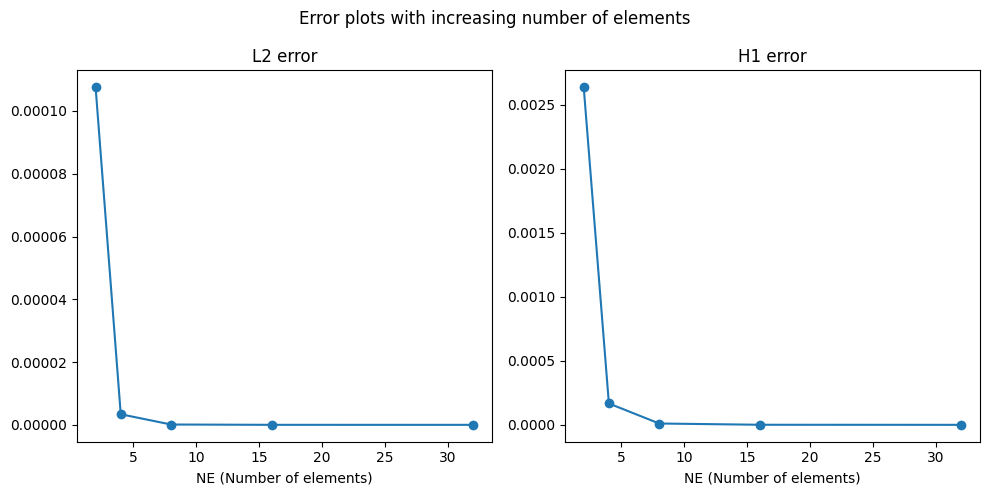

In [14]:
#plotting errors with number of elements
fig, ax  = plt.subplots(nrows=1,ncols=2, figsize = (10,5))

ax[0].plot(NE_values,L2_err,marker = "o")
ax[0].set_xlabel("NE (Number of elements)")
ax[0].set_title("L2 error")
ax[1].plot(NE_values,H1_err,marker = "o")
ax[1].set_xlabel("NE (Number of elements)")
ax[1].set_title("H1 error")

fig.suptitle("Error plots with increasing number of elements")
plt.tight_layout()

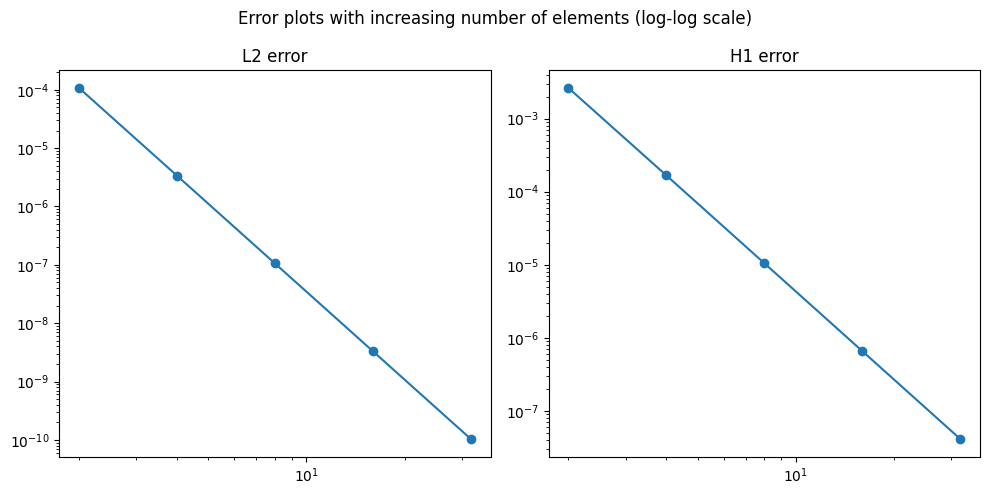

In [15]:
#plotting errors with number of elements in log-log scale
fig, ax  = plt.subplots(nrows=1,ncols=2, figsize = (10,5))

ax[0].plot(NE_values,L2_err,marker = "o")
ax[0].set_title("L2 error")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].plot(NE_values,H1_err,marker = "o")
ax[1].set_title("H1 error")
ax[1].set_xscale("log")
ax[1].set_yscale("log")

fig.suptitle("Error plots with increasing number of elements (log-log scale)")
plt.tight_layout()

#### Convergence behavior with increasing polynomial degree

In [16]:
a,b = 0,1                       #interval endpoints 
NE_values = [4,8]
N_values = np.arange(1,11)

for NE in NE_values:
    L2_err = []
    H1_err = []
    for N in N_values:
        K, F = assemble_global_system(N, NE, f_func, a,b, alpha,beta, gamma)

        # Build global node coordinates X
        X = np.zeros(N*NE+1)
        h = (b-a)/NE
        for i in range(NE):
            xi_ref, _ = compute_nodes_weights(N)
            xi, xi_1 = a + i*h, a + (i+1)*h
            X[i*N:(i+1)*N+1] = 0.5*(xi+xi_1) + 0.5*(xi_1-xi)*xi_ref

        # Enforce boundary conditions
        apply_dirichlet(K, F)

        # Solve linear system
        u_num = np.linalg.solve(K, F)

        # Compute errors
        l2_err, h1_err = compute_errors(u_num, X, N, NE, u_exact,du_exact, a,b)
        L2_err.append(l2_err)
        H1_err.append(h1_err)
    L2_err = np.array(L2_err)
    H1_err = np.array(H1_err)
    L2_rate = prepend_nan(spectral_rates(L2_err,N_values))
    H1_rate = prepend_nan(spectral_rates(H1_err,N_values))

    print("-"*50)
    print("NE =",NE)
    df = pd.DataFrame(data=np.transpose([N_values,L2_err,L2_rate,H1_err,H1_rate]),columns=["Polynomial Degree", "L2-Error","L2-Rate", "H1-Error","H1-Rate"])
    print(df)

--------------------------------------------------
NE = 4
   Polynomial Degree      L2-Error   L2-Rate      H1-Error   H1-Rate
0                1.0  1.772150e-02       NaN  5.091862e-01       NaN
1                2.0  2.033514e-03  2.165013  5.120981e-02  2.296883
2                3.0  8.983626e-05  3.119532  3.378200e-03  2.718588
3                4.0  3.374269e-06  3.281810  1.669890e-04  3.007170
4                5.0  1.078711e-07  3.442997  6.590998e-06  3.232223
5                6.0  2.981923e-09  3.588369  2.164989e-07  3.415874
6                7.0  7.245808e-11  3.717316  6.090124e-09  3.570917
7                8.0  1.569285e-12  3.832388  1.498087e-10  3.705065
8                9.0  3.784547e-14  3.724864  3.274529e-12  3.823185
9               10.0  1.989933e-14  0.642825  2.154928e-13  2.721002
--------------------------------------------------
NE = 8
   Polynomial Degree      L2-Error   L2-Rate      H1-Error   H1-Rate
0                1.0  4.218642e-03       NaN  2.525160e-

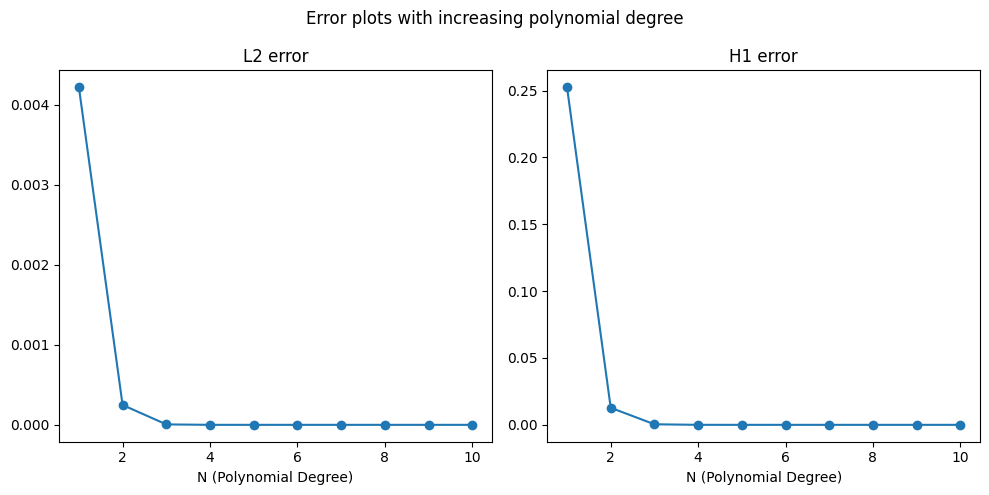

In [17]:
#plotting the errors with polynomial degree
fig, ax  = plt.subplots(nrows=1,ncols=2, figsize = (10,5))

ax[0].plot(N_values,L2_err,marker = "o")
ax[0].set_xlabel("N (Polynomial Degree)")
ax[0].set_title("L2 error")
ax[1].plot(N_values,H1_err,marker = "o")
ax[1].set_xlabel("N (Polynomial Degree)")
ax[1].set_title("H1 error")

fig.suptitle("Error plots with increasing polynomial degree")
plt.tight_layout()

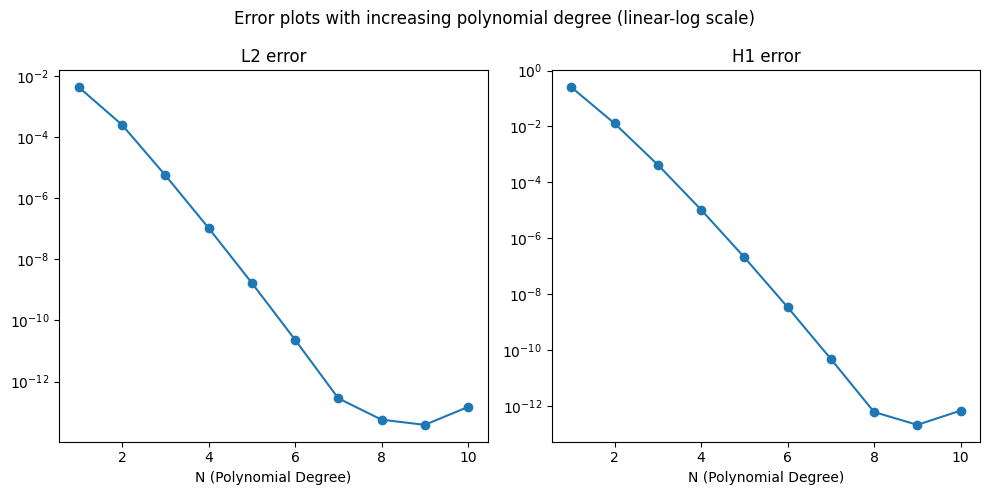

In [18]:
#plotting the errors with polynomial degree in linear-log scale
fig, ax  = plt.subplots(nrows=1,ncols=2, figsize = (10,5))

ax[0].plot(N_values,L2_err,marker = "o")
ax[0].set_xlabel("N (Polynomial Degree)")
ax[0].set_title("L2 error")
ax[0].set_yscale("log")
ax[1].plot(N_values,H1_err,marker = "o")
ax[1].set_xlabel("N (Polynomial Degree)")
ax[1].set_title("H1 error")
ax[1].set_yscale("log")

fig.suptitle("Error plots with increasing polynomial degree (linear-log scale)")
plt.tight_layout()